In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import os
import mahotas as mh
from colicoords import iter_subplots
from symfit import Parameter, Variable, Fit, Model, exp, sqrt, pi
from symfit.core.minimizers import MINPACK

In [53]:
data_dir = r'.'  # Replace by data directory path
folders = ['Cy3B_NHS', 'eGFP']

# Correcting brightfield images

Brightfield images are flattened by dividing the images by their median image.

In [54]:
for f in folders:
    bf_raw = tifffile.imread(os.path.join(data_dir, f, 'Brightfield.tif'))
    median_bf = np.median(bf_raw, axis=0)
    bf_flat = bf_raw / median_bf
    tifffile.imsave(os.path.join(data_dir, f, 'Bf_corrected.tif'), bf_flat)

# Generating a beamprofile

A beamprofile image is recorded by imaging homogeneous fluorescence from a fluorecent marker on a microscope coverslide. The beamprofile is smoothed wih a gaussian filter and then fitted to a bivariate normal distribution.

In [9]:
beamprofile = tifffile.imread(os.path.join(data_dir, 'Beamprofile.tif'))

bp_mean = beamprofile.mean(axis=0)
bp_f = mh.gaussian_filter(bp_mean, 15)
s = np.sum(bp_f)
bp_f /= s

<IPython.core.display.Javascript object>


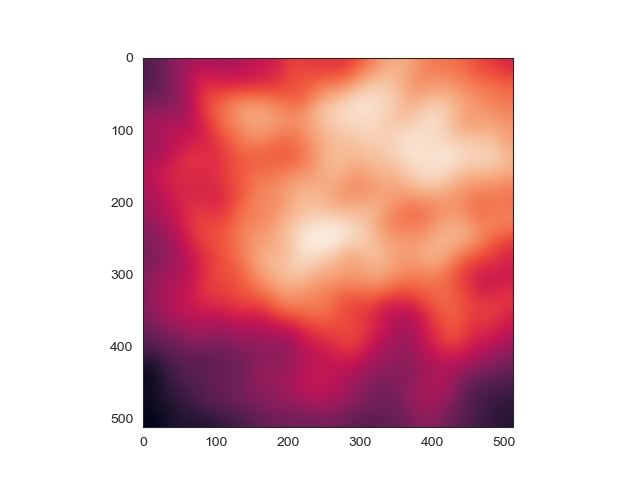

In [10]:
plt.figure()
plt.imshow(bp_f)

In the two cells below, we create a Symfit model for a bivariate normal distribution with a constant background value, according to the following expression:

\begin{equation}
\frac{A}{2 \pi \sigma_{X} \sigma_{Y} \sqrt{1-\rho^{2}}} \exp \left(-\frac{1}{2\left(1-\rho^{2}\right)}\left[\frac{\left(x-\mu_{X}\right)^{2}}{\sigma_{X}^{2}}+\frac{\left(y-\mu_{Y}\right)^{2}}{\sigma_{Y}^{2}}-\frac{2 \rho\left(x-\mu_{X}\right)\left(y-\mu_{Y}\right)}{\sigma_{X} \sigma_{Y}}\right]\right) + bg\end{equation}

In [11]:
amp = Parameter(name='amp', value=1)
sig_x = Parameter(name='sig_x', value=400)
sig_y = Parameter(name='sig_y', value=400)
mu_x = Parameter(name='mu_x', value=250)
mu_y = Parameter(name='mu_y', value=250)
rho = Parameter(name='rho', value=0)
x_var = Variable(name='x_var')
y_var = Variable(name='y_var')
z_var = Variable(name='z_var')

bg = 1800 / s

In [12]:
z = (
    (x_var - mu_x)**2/sig_x**2
    + (y_var - mu_y)**2/sig_y**2
    - 2 * rho * (x_var - mu_x) * (y_var - mu_y)/(sig_x * sig_y)
)
model = {
    z_var: amp*exp(
        - z / (2 * (1 - rho**2)))
        / (2 * pi * sig_x * sig_y * sqrt(1 - rho**2)
    ) + bg
}

Creating arrays of x- and y-coordinates:

In [14]:
Y, X = np.indices(bp_f.shape)
X.shape, Y.shape

((512, 512), (512, 512))

Fitting the model to the data, using the MINPACK minimizer.

In [15]:
fit = Fit(model, z_var=bp_f, x_var=X, y_var=Y, minimizer=MINPACK)
res = fit.execute(ftol=1e-12)
print(res)


Parameter Value        Standard Deviation
amp       2.790926e+00 2.338766e-03
mu_x      3.329743e+02 1.461587e-01
mu_y      1.573221e+02 1.331246e-01
rho       -1.448674e-01 6.142643e-04
sig_x     4.030749e+02 2.834852e-01
sig_y     3.645497e+02 2.138820e-01
Fitting status message: The relative error between two consecutive iterates is at most 0.000000
Number of iterations:   57
Regression Coefficient: 0.9234717536658616



In [16]:
output = fit.model(x_var=X, y_var=Y, **res.params)

<IPython.core.display.Javascript object>


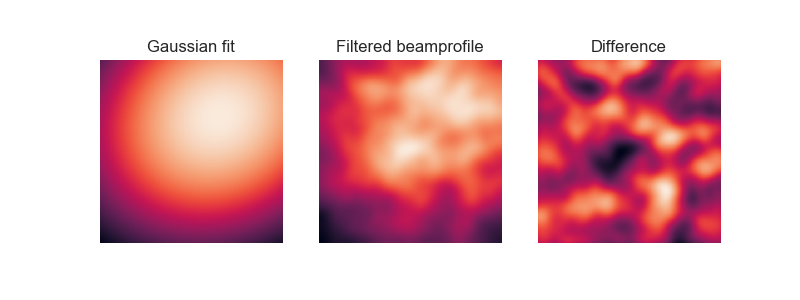

1.557326232234613

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(8,3))
for a in axes:
    a.axis('off')
axes[0].imshow(output[0])
axes[0].set_title('Gaussian fit')
axes[1].imshow(bp_f)
axes[1].set_title('Filtered beamprofile')
axes[2].imshow(output[0] - bp_f)
axes[2].set_title('Difference')
output[0].max() / output[0].min()

In [23]:
bp_norm = output[0] / output[0].max()
tifffile.imsave(os.path.join(data_dir, 'Beamprofile_fit_norm.tif'), bp_norm)

# Correcting the fluorescence images

Fluorescence images are corrected by subtracting median backgrond fluorescence and then dividing them by the beamprofile.

In [44]:
flu_list = []
out_list = []

for f in folders:
    flu = tifffile.imread(os.path.join(data_dir, f, 'Fluorescence.tif'))
    bg = np.median(flu)
    flu_corrected = (flu - bg) / bp_norm
    flu_list.append(flu)
    out_list.append(flu_corrected)
    tifffile.imsave(os.path.join(data_dir, f, 'Flu_corrected.tif'), flu_corrected)

<IPython.core.display.Javascript object>


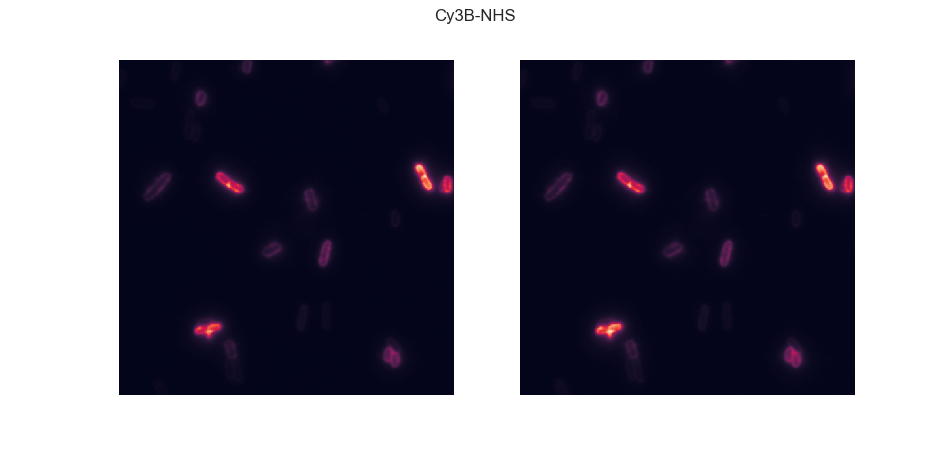

In [50]:
fig, axes = iter_subplots(1, 2, figsize=(9.5,4.5))
for a in axes:
    a.axis('off')
fig.suptitle("Cy3B-NHS")
axes[0].iter_imshow(flu_list[0])
axes[1].iter_imshow(out_list[0])
fig.display()

<IPython.core.display.Javascript object>


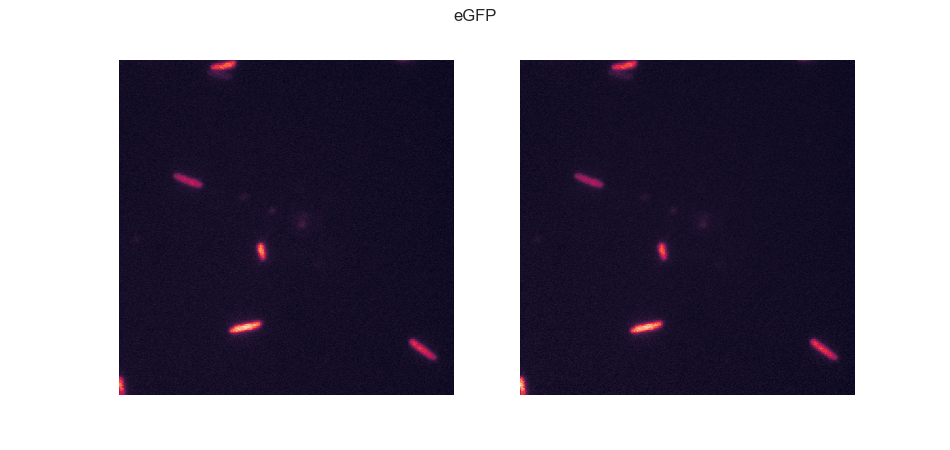

In [49]:
fig, axes = iter_subplots(1, 2, figsize=(9.5,4.5))
for a in axes:
    a.axis('off')
fig.suptitle("eGFP")
axes[0].iter_imshow(flu_list[1])
axes[1].iter_imshow(out_list[1])
fig.display()